In [35]:
%matplotlib inline
import matplotlib.pyplot as plt
import nivapy
import imp
import pandas as pd
import os

# NOPE runs for the MARTINI project

Based on a brief chat with André on 24/01/2018, for the MARTINI project we need to run the NOPE model for 2012 to 2016 inclusive. This is done here.

**NOTE:** NOPE is not yet fully tested - use these results with caution! For comparison, I will also provide load estimates based on the monthly measured data in the 11 main RID rivers.

## 1. Connect to NIVABASE

In [36]:
# Connect to NIVABASE
ora_eng = nivapy.da.connect(src='nivabase')

Username: ········
Password: ········
Connection successful.


## 2. Load NOPE

In [37]:
# Import NOPE model
nope_path = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
             r'\Python\rid\notebooks\nope.py')
nope = imp.load_source('nope', nope_path)

## 3. User input

In [38]:
# Period of interest
st_yr, end_yr = 2012, 2016

# Parameters of interest
par_list = ['Tot-N', 'Tot-P']

# Folder containing core NOPE data
nope_fold = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
             r'\NOPE\NOPE_Core_Input_Data')

# Folder for annual NOPE data
ann_fold = (r'C:\Data\James_Work\Staff\Phil_W\MARTINI\NOPE'
            r'\NOPE_Annual_Inputs_2012-2016')

# Folder for NOPE results file
res_fold = (r'C:\Data\James_Work\Staff\Phil_W\MARTINI\NOPE'
            r'\NOPE_Results_2012-2016')

## 4. Generate model input files from the NIVABASE

In [39]:
# Loop over years
for year in range(st_yr, end_yr+1):
    # Make input file
    ann_csv = os.path.join(ann_fold, 'nope_input_data_%s.csv' % year)   
    df = nope.make_rid_input_file(year, ora_eng, nope_fold, ann_csv,
                                  par_list=par_list)

## 5. Run model

In [40]:
# Loop over years
for year in range(st_yr, end_yr+1):
    # Run model
    ann_csv = os.path.join(ann_fold, 'nope_input_data_%s.csv' % year) 
    g = nope.run_nope(ann_csv, par_list)
    
    # Save results
    res_csv = os.path.join(res_fold, 'nope_results_%s.csv' % year)
    df = nope.model_to_dataframe(g, out_path=res_csv)

## 6. Compare to observations

As a quick check, we can compare the output from NOPE to the monitored loads calculated for the RID programme. The code below is messy as it's taken directly from my [NOPE autocalibration notebook](http://nbviewer.jupyter.org/github/JamesSample/rid/blob/master/notebooks/calibrating_nope.ipynb), which attempts to do more than just compare modelled versus observed values. This code essentially sets up the model for MCMC-based autocalibration, but as a side effect it also generates dataframes of modelled versus observed values, which is all I'm interested in here.

In [41]:
# Read obs data
obs_df, cal_df, val_df = nope.read_obs_data(1)

# Build input dict
par_list_lo = [i.lower() for i in par_list]
in_data = nope.build_input_dict(st_yr, end_yr, par_list_lo)

# Get catch IDs with calib data
calib_nds = set(cal_df['nve_vassdrag_nr'].values)

# Pre-build network for speed
in_path = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
           r'\NOPE\NOPE_Annual_Inputs\nope_input_data_1990.csv')
g, nd_list = nope.build_calib_network(in_path, calib_nds)

# Run model with default TEOTIL params
df = nope.run_model_multi_year(g, nd_list, st_yr, end_yr, in_data, 
                               par_list_lo, calib_nds, cal_pars=None)

# Join results to obs data
df = pd.merge(obs_df, df, how='left',
              left_on=['nve_vassdrag_nr', 'year'],
              right_on=['regine', 'year'])

# Convert obs flow to m3/s
df['obs_q_m3/s'] = df['mean_q_1000m3/day']*1000/(24*60*60)
del df['mean_q_1000m3/day']

# Drop NaNs (obs_df contains data from 1990; 
# we're just interested in post-2012)
df.dropna(how='any', inplace=True)

df.head()

,station_id,year,obs_tot-p_tonnes,obs_tot-n_tonnes,nve_vassdrag_nr,rid_group,regine,q_m3/s,tot-n_tonnes,tot-p_tonnes,obs_q_m3/s
17,29615,2012,66.609294,1841.825593,015.A1,rid_11,015.A1,148.205993,1754.601156,29.953582,139.993119
18,29615,2013,51.470468,1769.431615,015.A1,rid_11,015.A1,155.894762,1805.624885,29.980421,119.600011
19,29615,2014,65.443444,2005.081312,015.A1,rid_11,015.A1,191.415389,1934.659873,30.057409,139.256585
20,29615,2015,54.316502,1835.821707,015.A1,rid_11,015.A1,180.523866,1950.672556,31.364638,130.623199
21,29615,2016,24.766783,1352.479093,015.A1,rid_11,015.A1,143.865569,1728.090234,29.377923,111.981208


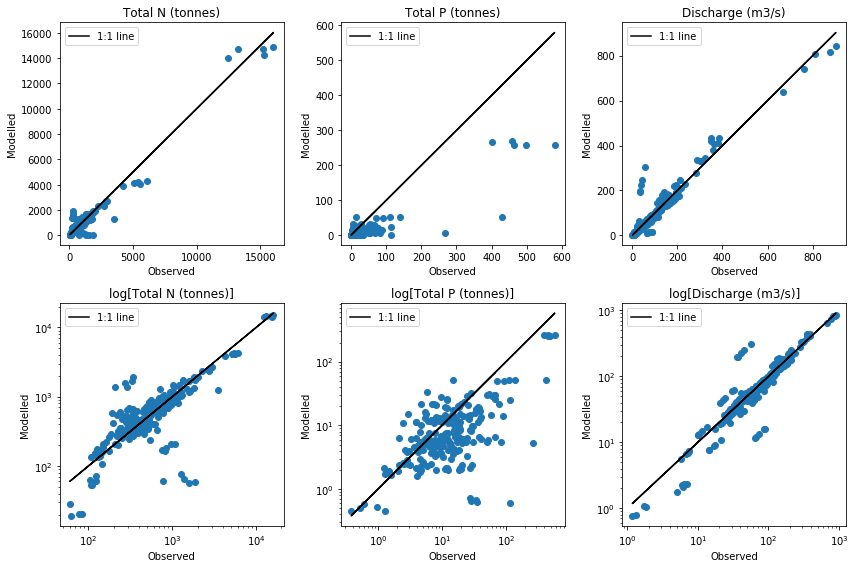

In [42]:
def plot_mod_obs(df):
    """ Simple plot to asses goodness-of-fit of model results.
    
    Args:
        df: Dataframe of modelled and observed values.
        
    Returns:
        None
    """
    # Plot
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12,8))

    # Pairs to plot
    data_pairs = [('Total N (tonnes)', 'obs_tot-n_tonnes', 'tot-n_tonnes'),
                  ('Total P (tonnes)','obs_tot-p_tonnes', 'tot-p_tonnes'),
                  ('Discharge (m3/s)', 'obs_q_m3/s', 'q_m3/s')]

    # Loop over pairs
    for idx, item in enumerate(data_pairs):
        # Plot un-logged
        axes[0, idx].plot(df[item[1]], df[item[2]], 'o', label='')
        axes[0, idx].plot(df[item[1]], df[item[1]], 'k-', label='1:1 line')
        axes[0, idx].set_xlabel('Observed')
        axes[0, idx].set_ylabel('Modelled')
        axes[0, idx].set_title(item[0])
        axes[0, idx].legend(loc='upper left')

        # Plot logged
        axes[1, idx].plot(df[item[1]], df[item[2]], 'o', label='')
        axes[1, idx].plot(df[item[1]], df[item[1]], 'k-', label='1:1 line')
        axes[1, idx].set_xlabel('Observed')
        axes[1, idx].set_ylabel('Modelled')
        axes[1, idx].set_title('log[%s]' % item[0])
        axes[1, idx].legend(loc='upper left')
        axes[1, idx].set_xscale('log')
        axes[1, idx].set_yscale('log')

    plt.tight_layout()
    
    return None

# Plot results
plot_mod_obs(df)

The results using the default TEOTIL parameters aren't very good, especially for Total P. I've begun some further work to calibrate the model (see [here](http://nbviewer.jupyter.org/github/JamesSample/rid/blob/master/notebooks/calibrating_nope.ipynb)), but haven't had chance to make much progress recently.